In [1]:
import os
from tqdm import tqdm
import math
import numpy as np
import pandas as pd

from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_curve, auc, average_precision_score, roc_auc_score
from scipy import stats

from src.utils import parse_filename, normalize, sliding_window

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

from xstream.python.Chains import Chains

import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'
mpl.rc('font', family='serif')

In [2]:
data_name = "synth"

if data_name == "xdk" or data_name == "MHEALTHDATASET" or "pmsm_temperature_data":
    data = []
    directory = os.path.join(os.getcwd(), "data", data_name)
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".csv"):
                print("Read {}".format(file))
                data.append(np.loadtxt(os.path.join(directory, file), skiprows=1, delimiter=","))
    data = np.array(data)
if data_name == "synth":
    data = np.load(os.path.join(os.getcwd(), "data", "synth", "10_10000_100_0.2_0.2_0.01_0.4_0.2_local_d.npy"))
    
print("Executing on {} data".format(data_name))

Executing on synth data


In [3]:
min_length = min([len(d) for d in data])
max_length = 10000
indices = np.random.choice(np.arange(min_length), min(min_length, max_length), replace=False)
trimmed_data = np.array([d[indices] for d in data])

In [4]:
contamination = 0.01
percentile = (1-contamination)*100
percentile

99.0

In [5]:
oldshape = trimmed_data.shape
trimmed_data = np.reshape(trimmed_data, newshape=(trimmed_data.shape[0]*trimmed_data.shape[1], trimmed_data.shape[2]))
clf = LocalOutlierFactor(n_neighbors=20, contamination=contamination, novelty=True)
clf.fit(trimmed_data)
labels_global = clf.predict(trimmed_data) == -1
# labels = np.reshape(predictions, newshape=(oldshape[0], oldshape[1]))
trimmed_data = np.reshape(trimmed_data, newshape=oldshape)

In [6]:
predictions_global = -clf.negative_outlier_factor_

In [7]:
models = [LocalOutlierFactor(n_neighbors=20, contamination=contamination, novelty=True) for _ in range(trimmed_data.shape[0])]
[model.fit(trimmed_data[i]) for i, model in enumerate(models)]
# labels_local = np.array([model.predict(trimmed_data[i]) == -1 for i, model in enumerate(models)]).flatten()
predictions_local = np.array([-model.negative_outlier_factor_ for i, model in enumerate(models)])

In [8]:
result_local = predictions_local
result_global = predictions_global

In [9]:
outlier_thresh_local = np.percentile(result_local, percentile, axis=1, keepdims=True)
outlier_thresh_local = np.repeat(outlier_thresh_local, result_local.shape[-1], axis=-1)
labels_local = (result_local > outlier_thresh_local).flatten()
outlier_thresh_local.shape

(10, 10000)

In [10]:
outlier_thresh_global = np.percentile(result_global, q=percentile)
labels_global = (result_global > outlier_thresh_global).flatten()
np.sum(labels_global)

1000

In [11]:
result_local = np.reshape(result_local, newshape=result_global.shape)

In [12]:
print("The fraction of local outliers for {} is {}".format(
    data_name, 
    1 - np.sum(np.logical_and(labels_global.flatten(), labels_local))/np.sum(labels_local)
))

The fraction of local outliers for synth is 0.14800000000000002


(100000,)

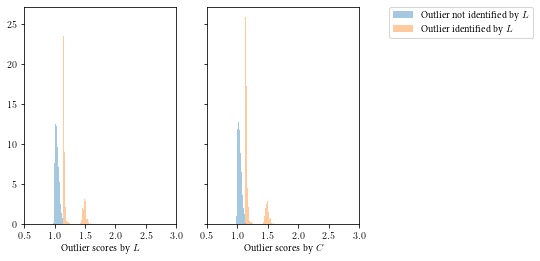

In [13]:
fig, axes = plt.subplots(1, 2, sharey=True)

ax = axes[0]
sns.distplot(result_local[np.invert(labels_local.flatten())], 
             hist=True, rug=False, kde=False, 
             rug_kws={"alpha": 0.3}, norm_hist=True, 
             ax=ax)

sns.distplot(result_local[labels_local.flatten()], 
             hist=True, rug=False, kde=False, 
             rug_kws={"alpha": 0.5}, norm_hist=True, 
             ax=ax)

ax.set_xlim((0.5, 3))
ax.set_xlabel("Outlier scores by $L$")

ax = axes[1]

sns.distplot(result_global[np.invert(labels_local.flatten())], 
             hist=True, rug=False, kde=False, norm_hist=True, 
             rug_kws={"alpha": 0.3}, label="Outlier not identified by $L$", 
             ax=ax)

sns.distplot(result_global[labels_local.flatten()], 
             hist=True, rug=False, kde=False, 
             rug_kws={"alpha": 0.5}, norm_hist=True, 
             label="Outlier identified by $L$", 
             ax=ax)


ax.set_xlim((0.5, 3))
plt.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

ax.set_xlabel("Outlier scores by $C$")
# plt.tight_layout()
result_global.shape

Text(0.5, 0, 'Global OS, local labels')

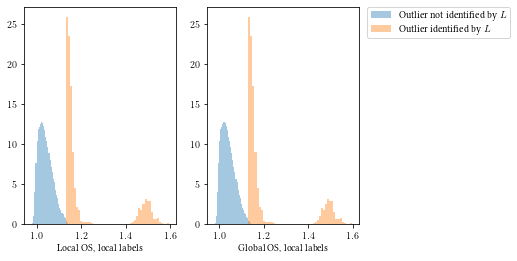

In [14]:
ax = plt.subplot(121)

sns.distplot(result_local[np.invert(labels_local.flatten())], 
             hist=True, rug=False, kde=False, 
             rug_kws={"alpha": 0.3}, norm_hist=True)

sns.distplot(result_local[labels_local.flatten()], 
             hist=True, rug=False, kde=False, 
             rug_kws={"alpha": 0.5}, norm_hist=True)

# ax.set_xlim((0.5, 6))
ax.set_xlabel("Local OS, local labels")

ax = plt.subplot(122)

sns.distplot(result_global[np.invert(labels_local.flatten())], 
             hist=True, rug=False, kde=False, norm_hist=True, 
             rug_kws={"alpha": 0.3}, label="Outlier not identified by $L$")

sns.distplot(result_global[labels_local.flatten()], 
             hist=True, rug=False, kde=False, 
             rug_kws={"alpha": 0.5}, norm_hist=True, 
             label="Outlier identified by $L$")


# ax.set_xlim((0.5, 6))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set_xlabel("Global OS, local labels")

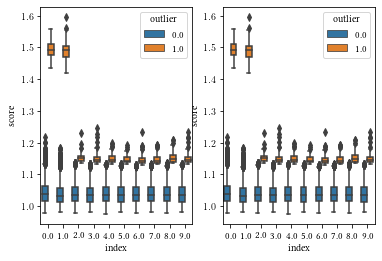

In [15]:
result_global = np.reshape(result_global, newshape=(oldshape[0], oldshape[1]))
result_local = np.reshape(result_local, newshape=(oldshape[0], oldshape[1]))
labels_global = np.reshape(labels_global, newshape=(oldshape[0], oldshape[1]))
labels_local = np.reshape(labels_local, newshape=(oldshape[0], oldshape[1]))

# Local data
fig, axes = plt.subplots(1, 2, sharey=False)

device_index = np.array([i for i, results in enumerate(result_local) for _ in results])
result_local = np.reshape(result_local, newshape=(oldshape[0]*oldshape[1]))
labels_local = np.reshape(labels_local, newshape=(oldshape[0]*oldshape[1]))
df = pd.DataFrame(np.array([device_index,
                            result_local, labels_local]).T, columns=["index", "score", "outlier"])
sns.boxplot(x="index", y="score", data=df, hue="outlier", ax=axes[0])

device_index = np.array([i for i, results in enumerate(result_global) for _ in results])
result_global = np.reshape(result_global, newshape=(oldshape[0]*oldshape[1]))
labels_local = np.reshape(labels_local, newshape=(oldshape[0]*oldshape[1]))
df = pd.DataFrame(np.array([device_index,
                            result_global, labels_local]).T, columns=["index", "score", "outlier"])
sns.boxplot(x="index", y="score", data=df, hue="outlier", ax=axes[1])

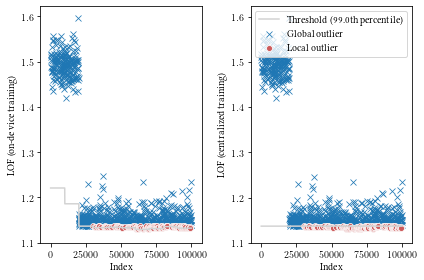

In [16]:
x = np.array([i for i in range(len(result_global))])

# labels_local and not labels_global
is_local_outlier = np.logical_and(labels_local, result_global < np.percentile(result_global, percentile))
is_global_outlier = np.logical_and(np.invert(is_local_outlier), labels_local)

plt.subplot(121)

sns.lineplot(x, outlier_thresh_local.flatten(), 
                 alpha=1, color="lightgrey")
sns.scatterplot(x[is_global_outlier], result_local[is_global_outlier], 
                alpha=1.0, marker="x")
sns.scatterplot(x[is_local_outlier], result_local[is_local_outlier], 
                color="indianred")

plt.xlabel("Index")
plt.ylabel("LOF (on-device training)")

ax = plt.subplot(122)

sns.lineplot(x, outlier_thresh_global, 
                 alpha=1, color="lightgrey", label="Threshold ({}th percentile)".format(percentile))
sns.scatterplot(x[is_global_outlier], result_global[is_global_outlier], 
                alpha=1.0, marker="x", label="Global outlier")
sns.scatterplot(x[is_local_outlier], result_global[is_local_outlier], 
                color="indianred", alpha=1.0, label="Local outlier")

plt.legend(loc="upper right")
plt.xlabel("Index")
plt.ylabel("LOF (centralized training)")

plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "figures", "results", "mhealth_comparison_local_central_lof.pdf"))
plt.show()

In [17]:
x = np.array([i for i in range(len(predictions_central))])

is_local_outlier = np.logical_and(labels_local, np.invert(labels_central), labels_local)
is_global_outlier = np.logical_and(labels_central, np.invert(labels_local), labels_central)
# is_local_outlier = np.logical_and(labels_central != labels_local, labels_local)
# is_global_outlier = np.logical_and(labels_central == labels_local, labels_central)

plt.subplot(121)

x_in = np.random.choice(x[np.invert(labels_local)], np.sum(labels_local)*10, replace=False)
sns.scatterplot(x_in, predictions_local[x_in], alpha=0.2, color="grey")
sns.scatterplot(x[labels_local], predictions_local[labels_local], alpha=0.4, 
                color="sandybrown", marker="s")
sns.scatterplot(x[labels_local], predictions_local[labels_local], 
                color="indianred", marker="^")

plt.xlabel("Index")
plt.ylabel("Outlier Score (on-device training)")

ax = plt.subplot(122)

x_in = np.random.choice(x[np.invert(labels_local)], np.sum(labels_local)*10, replace=False)
sns.scatterplot(x_in, predictions_central[x_in], alpha=0.2, color="grey", label="is inlier")
sns.scatterplot(x[labels_local], predictions_central[labels_local], alpha=0.4, color="sandybrown", 
                label="is global outlier", marker="s")
sns.scatterplot(x[labels_local], predictions_central[labels_local], color="indianred", 
                label="is local outlier", marker="^", alpha=1.0)

plt.xlabel("Index")
plt.ylabel("Outlier Score (centralized training)")
plt.legend()

plt.tight_layout()
# plt.savefig(os.path.join(os.getcwd(), "figures", "results", "eMotor_comparison_local_central_lof.pdf"))
plt.show()

NameError: name 'predictions_central' is not defined